# IEEE-CIS Fraud Detection - Exploratory Data Analysis

This notebook provides comprehensive EDA for the IEEE-CIS Fraud Detection dataset including:
- Data overview and summary statistics
- Missing value analysis
- Distribution analysis (numerical and categorical)
- Fraud class balance analysis
- Correlation analysis
- Temporal patterns
- Interactive visualizations

## Setup and Imports

In [48]:
import os
import sys
import warnings
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Interactive visualizations
try:
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    PLOTLY_AVAILABLE = True
except ImportError:
    PLOTLY_AVAILABLE = False
    print("Warning: plotly not installed. Run: pip install plotly")

warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline

print("Setup complete!")

Setup complete!


## Configuration

In [2]:
# Path to IEEE_CIS data directory
DATA_PATH = "../data/IEEE_CIS"

# Sample fraction (set to None to use all data, or 0.1 for 10%)
SAMPLE_FRACTION = 0.1  # Use 10% for faster exploration

# Output directory for saved figures
OUTPUT_DIR = "eda_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

---
# 1. Data Loading

In [3]:
# Load transaction data
transaction_path = os.path.join(DATA_PATH, "raw", "train_transaction.csv")
print(f"Loading transactions from: {transaction_path}")

# Define dtypes for efficient loading
dtype_dict = {f'V{i}': 'float32' for i in range(1, 340)}
dtype_dict.update({f'C{i}': 'float32' for i in range(1, 15)})
dtype_dict.update({f'D{i}': 'float32' for i in range(1, 16)})
dtype_dict.update({f'M{i}': 'object' for i in range(1, 10)})
dtype_dict['TransactionAmt'] = 'float32'
dtype_dict['TransactionDT'] = 'int64'
dtype_dict['isFraud'] = 'int8'

transactions = pd.read_csv(transaction_path, dtype=dtype_dict)
print(f"Loaded {len(transactions):,} transactions")

Loading transactions from: ../data/IEEE_CIS/raw/train_transaction.csv
Loaded 590,540 transactions


In [4]:
# Load identity data
identity_path = os.path.join(DATA_PATH, "raw", "train_identity.csv")
print(f"Loading identity from: {identity_path}")

identity = pd.read_csv(identity_path)
print(f"Loaded {len(identity):,} identity records")

Loading identity from: ../data/IEEE_CIS/raw/train_identity.csv
Loaded 144,233 identity records


In [5]:
# Merge datasets
print("Merging datasets...")
data = transactions.merge(identity, on='TransactionID', how='left')
print(f"Merged data: {len(data):,} rows, {len(data.columns)} columns")

del transactions, identity  # Free memory

Merging datasets...
Merged data: 590,540 rows, 434 columns


In [6]:
# Optional: Sample data for faster exploration
if SAMPLE_FRACTION is not None and SAMPLE_FRACTION < 1.0:
    print(f"Sampling {SAMPLE_FRACTION*100:.1f}% of data...")
    data = data.sample(frac=SAMPLE_FRACTION, random_state=42).reset_index(drop=True)
    print(f"Sampled data: {len(data):,} rows")

Sampling 10.0% of data...
Sampled data: 59,054 rows


In [7]:
# Add datetime column
reference_date = datetime(2017, 11, 30)
data['datetime'] = pd.to_datetime(
    data['TransactionDT'].apply(lambda x: reference_date + timedelta(seconds=int(x)))
)
print(f"Date range: {data['datetime'].min()} to {data['datetime'].max()}")

Date range: 2017-12-01 00:01:09 to 2018-05-31 23:49:23


---
# 2. Data Overview

In [8]:
print("="*60)
print("DATA OVERVIEW")
print("="*60)

print(f"\nShape: {data.shape[0]:,} rows × {data.shape[1]} columns")
print(f"Memory usage: {data.memory_usage(deep=True).sum() / 1e9:.2f} GB")

print("\nColumn Types:")
type_counts = data.dtypes.value_counts()
for dtype, count in type_counts.items():
    print(f"  {dtype}: {count} columns")

DATA OVERVIEW

Shape: 59,054 rows × 435 columns
Memory usage: 0.18 GB

Column Types:
  float32: 369 columns
  object: 31 columns
  float64: 30 columns
  int64: 3 columns
  int8: 1 columns
  datetime64[ns]: 1 columns


In [9]:
# Categorize columns
v_cols = [c for c in data.columns if c.startswith('V')]
c_cols = [c for c in data.columns if c.startswith('C') and c[1:].isdigit()]
d_cols = [c for c in data.columns if c.startswith('D') and c[1:].isdigit()]
m_cols = [c for c in data.columns if c.startswith('M') and c[1:].isdigit()]
id_cols = [c for c in data.columns if c.startswith('id_')]

print("Column Groups:")
print(f"  V features (Vesta): {len(v_cols)} columns")
print(f"  C features (counting): {len(c_cols)} columns")
print(f"  D features (timedelta): {len(d_cols)} columns")
print(f"  M features (match): {len(m_cols)} columns")
print(f"  Identity features: {len(id_cols)} columns")

Column Groups:
  V features (Vesta): 339 columns
  C features (counting): 14 columns
  D features (timedelta): 15 columns
  M features (match): 9 columns
  Identity features: 38 columns


In [10]:
# First few rows
data.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,datetime
0,3457624,0,12153579,724.000000,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-04-19 15:59:39
1,3552820,0,15005886,108.500000,W,12544,321.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-05-22 16:18:06
2,3271083,0,6970178,47.950001,W,9400,111.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-02-18 16:09:38
3,3226689,0,5673658,100.598999,C,15885,545.0,185.0,visa,138.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-02-03 16:00:58
4,3268855,0,6886780,107.949997,W,15497,490.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-02-17 16:59:40


In [11]:
# Summary statistics for key numerical columns
key_num_cols = ['TransactionAmt', 'TransactionDT', 'card1', 'card2', 'card3', 'card5', 
                'addr1', 'addr2', 'dist1', 'dist2', 'isFraud']
key_num_cols = [c for c in key_num_cols if c in data.columns]
data[key_num_cols].describe()

,TransactionAmt,TransactionDT,card1,card2,card3,card5,addr1,addr2,dist1,dist2,isFraud
count,59054.000000,5.905400e+04,59054.000000,58150.000000,58897.000000,58603.000000,52513.000000,52513.000000,23775.000000,3698.000000,59054.000000
mean,135.235519,7.361627e+06,9895.574864,362.401273,153.201725,199.094278,290.156476,86.798355,114.328034,242.237696,0.035713
std,265.428741,4.606494e+06,4912.184523,157.903787,11.397095,41.423954,101.613678,2.658940,358.628359,566.938145,0.185575
min,0.350000,8.646900e+04,1007.000000,100.000000,100.000000,100.000000,100.000000,10.000000,0.000000,0.000000,0.000000
25%,43.290751,3.033211e+06,6019.000000,210.000000,150.000000,166.000000,204.000000,87.000000,3.000000,7.000000,0.000000
50%,68.500000,7.273272e+06,9653.000000,361.000000,150.000000,226.000000,299.000000,87.000000,8.000000,36.000000,0.000000
75%,125.000000,1.120739e+07,14259.000000,512.000000,150.000000,226.000000,330.000000,87.000000,24.000000,219.000000,0.000000
max,31937.390625,1.581056e+07,18393.000000,600.000000,231.000000,237.000000,536.000000,102.000000,6466.000000,11623.000000,1.000000


---
# 3. Missing Value Analysis

In [12]:
# Calculate missing values
missing = pd.DataFrame({
    'column': data.columns,
    'missing_count': data.isnull().sum().values,
    'missing_pct': (data.isnull().sum().values / len(data) * 100)
})
missing = missing.sort_values('missing_pct', ascending=False)
missing_only = missing[missing['missing_count'] > 0]

print(f"Columns with missing values: {len(missing_only)} / {len(data.columns)}")
print(f"Total missing cells: {data.isnull().sum().sum():,}")

Columns with missing values: 382 / 435
Total missing cells: 11,559,202


In [13]:
# Top 20 columns by missing percentage
missing_only.head(20)

,column,missing_count,missing_pct
417,id_24,58600,99.231212
418,id_25,58560,99.163477
400,id_07,58558,99.160091
401,id_08,58558,99.160091
414,id_21,58557,99.158397
415,id_22,58556,99.156704
420,id_27,58556,99.156704
419,id_26,58556,99.156704
416,id_23,58556,99.156704
14,dist2,55356,93.737935


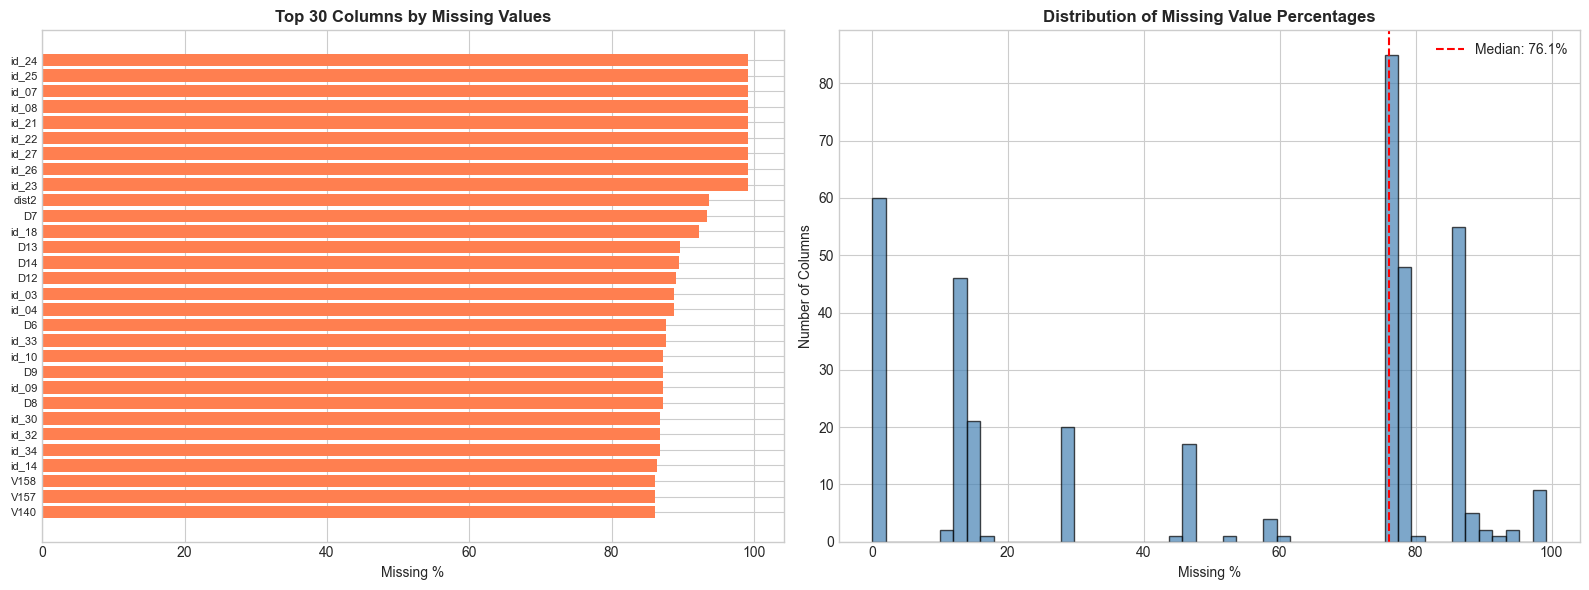

In [14]:
# Visualize missing values
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart of top 30 missing columns
top_missing = missing_only.head(30)
ax1 = axes[0]
ax1.barh(range(len(top_missing)), top_missing['missing_pct'].values, color='coral')
ax1.set_yticks(range(len(top_missing)))
ax1.set_yticklabels(top_missing['column'].values, fontsize=8)
ax1.set_xlabel('Missing %')
ax1.set_title('Top 30 Columns by Missing Values', fontsize=12, fontweight='bold')
ax1.invert_yaxis()

# Missing value distribution histogram
ax2 = axes[1]
ax2.hist(missing_only['missing_pct'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Missing %')
ax2.set_ylabel('Number of Columns')
ax2.set_title('Distribution of Missing Value Percentages', fontsize=12, fontweight='bold')
ax2.axvline(missing_only['missing_pct'].median(), color='red', linestyle='--', 
            label=f'Median: {missing_only["missing_pct"].median():.1f}%')
ax2.legend()

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'missing_values.png'), dpi=150, bbox_inches='tight')
plt.show()

---
# 4. Fraud Target Analysis

In [15]:
fraud_counts = data['isFraud'].value_counts()
fraud_pct = data['isFraud'].value_counts(normalize=True) * 100

print("Fraud Distribution:")
print(f"  Non-Fraud (0): {fraud_counts[0]:,} ({fraud_pct[0]:.2f}%)")
print(f"  Fraud (1):     {fraud_counts[1]:,} ({fraud_pct[1]:.2f}%)")
print(f"  Imbalance Ratio: {fraud_counts[0] / fraud_counts[1]:.1f}:1")

Fraud Distribution:
  Non-Fraud (0): 56,945 (96.43%)
  Fraud (1):     2,109 (3.57%)
  Imbalance Ratio: 27.0:1


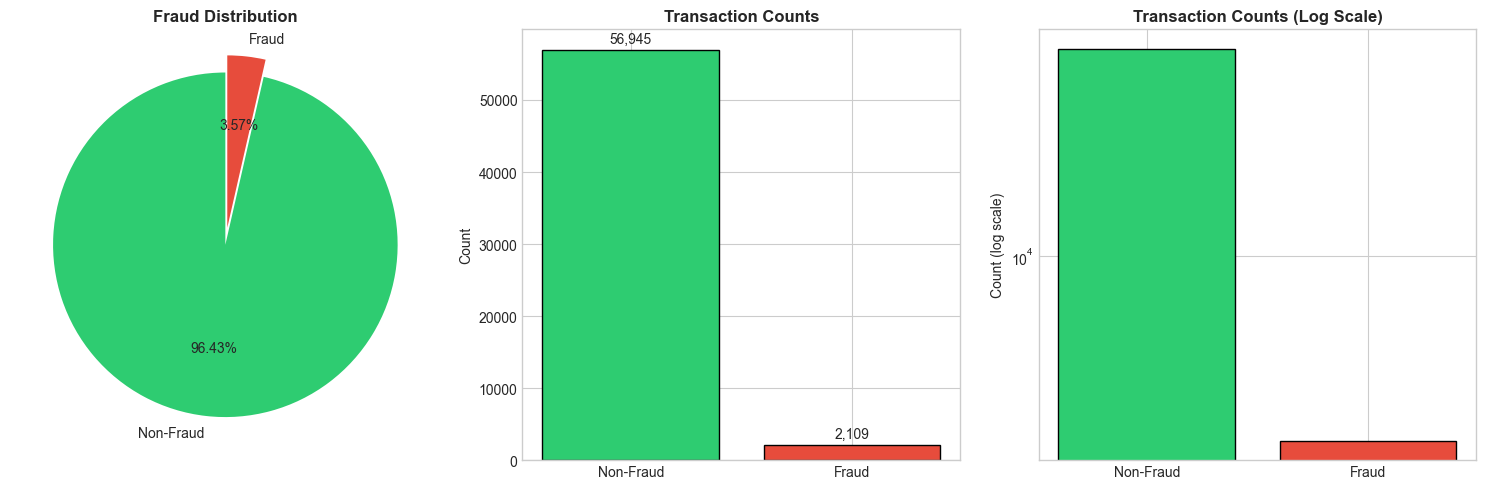

In [16]:
# Visualize fraud distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
colors = ['#2ecc71', '#e74c3c']

# Pie chart
ax1 = axes[0]
ax1.pie([fraud_counts[0], fraud_counts[1]], 
        explode=(0, 0.1), labels=['Non-Fraud', 'Fraud'],
        colors=colors, autopct='%1.2f%%', startangle=90)
ax1.set_title('Fraud Distribution', fontsize=12, fontweight='bold')

# Bar chart
ax2 = axes[1]
bars = ax2.bar(['Non-Fraud', 'Fraud'], [fraud_counts[0], fraud_counts[1]], 
               color=colors, edgecolor='black')
ax2.set_ylabel('Count')
ax2.set_title('Transaction Counts', fontsize=12, fontweight='bold')
for bar, val in zip(bars, [fraud_counts[0], fraud_counts[1]]):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000, 
            f'{val:,}', ha='center', fontsize=10)

# Log scale bar chart
ax3 = axes[2]
ax3.bar(['Non-Fraud', 'Fraud'], [fraud_counts[0], fraud_counts[1]], 
        color=colors, edgecolor='black')
ax3.set_ylabel('Count (log scale)')
ax3.set_yscale('log')
ax3.set_title('Transaction Counts (Log Scale)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'fraud_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

---
# 5. Transaction Amount Analysis

In [17]:
amount = data['TransactionAmt']
fraud = data['isFraud']

print("Overall Statistics:")
print(f"  Mean:   ${amount.mean():.2f}")
print(f"  Median: ${amount.median():.2f}")
print(f"  Std:    ${amount.std():.2f}")
print(f"  Min:    ${amount.min():.2f}")
print(f"  Max:    ${amount.max():.2f}")

print(f"\nBy Fraud Status:")
for label, name in [(0, 'Non-Fraud'), (1, 'Fraud')]:
    subset = amount[fraud == label]
    print(f"  {name}: Mean=${subset.mean():.2f}, Median=${subset.median():.2f}")

Overall Statistics:
  Mean:   $135.24
  Median: $68.50
  Std:    $265.43
  Min:    $0.35
  Max:    $31937.39

By Fraud Status:
  Non-Fraud: Mean=$134.73, Median=$68.00
  Fraud: Mean=$148.94, Median=$77.00


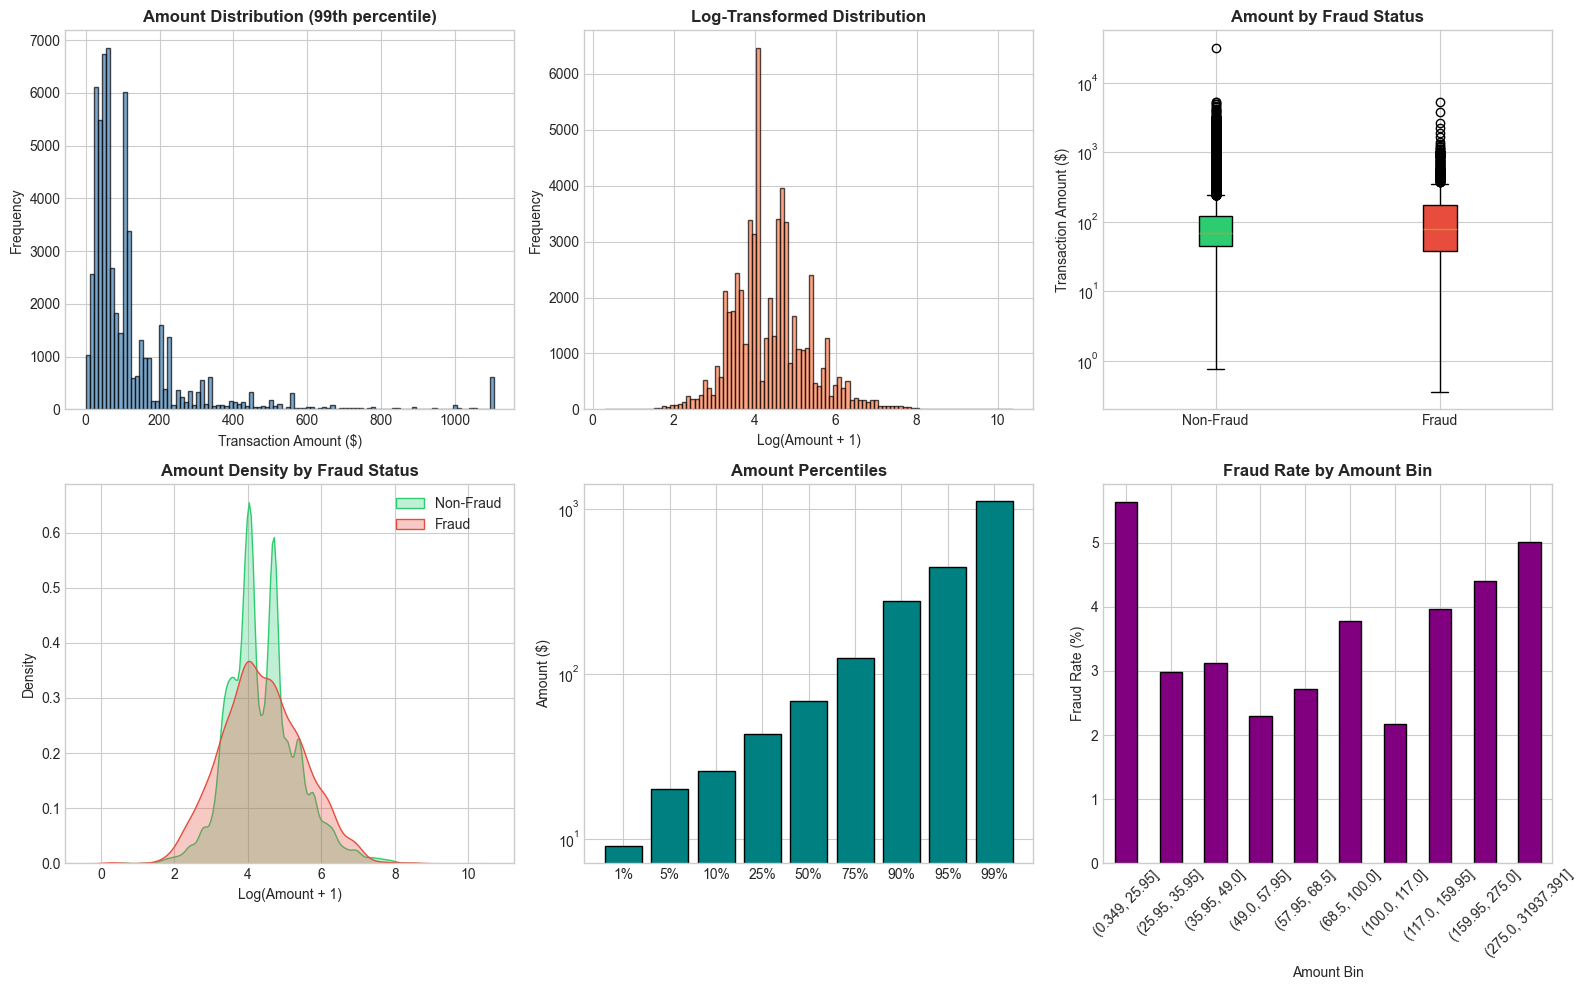

In [18]:
# Visualize transaction amounts
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Distribution (clipped)
ax = axes[0, 0]
ax.hist(amount.clip(upper=amount.quantile(0.99)), bins=100, 
        color='steelblue', edgecolor='black', alpha=0.7)
ax.set_xlabel('Transaction Amount ($)')
ax.set_ylabel('Frequency')
ax.set_title('Amount Distribution (99th percentile)', fontweight='bold')

# Log distribution
ax = axes[0, 1]
ax.hist(np.log1p(amount), bins=100, color='coral', edgecolor='black', alpha=0.7)
ax.set_xlabel('Log(Amount + 1)')
ax.set_ylabel('Frequency')
ax.set_title('Log-Transformed Distribution', fontweight='bold')

# Box plot by fraud
ax = axes[0, 2]
fraud_amounts = [amount[fraud == 0], amount[fraud == 1]]
bp = ax.boxplot(fraud_amounts, labels=['Non-Fraud', 'Fraud'], patch_artist=True)
bp['boxes'][0].set_facecolor('#2ecc71')
bp['boxes'][1].set_facecolor('#e74c3c')
ax.set_ylabel('Transaction Amount ($)')
ax.set_title('Amount by Fraud Status', fontweight='bold')
ax.set_yscale('log')

# Density by fraud status
ax = axes[1, 0]
for label, name, color in [(0, 'Non-Fraud', '#2ecc71'), (1, 'Fraud', '#e74c3c')]:
    subset = np.log1p(amount[fraud == label])
    sns.kdeplot(subset, ax=ax, label=name, color=color, fill=True, alpha=0.3)
ax.set_xlabel('Log(Amount + 1)')
ax.set_ylabel('Density')
ax.set_title('Amount Density by Fraud Status', fontweight='bold')
ax.legend()

# Amount percentiles
ax = axes[1, 1]
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
pct_values = [amount.quantile(p/100) for p in percentiles]
ax.bar(range(len(percentiles)), pct_values, color='teal', edgecolor='black')
ax.set_xticks(range(len(percentiles)))
ax.set_xticklabels([f'{p}%' for p in percentiles])
ax.set_ylabel('Amount ($)')
ax.set_title('Amount Percentiles', fontweight='bold')
ax.set_yscale('log')

# Fraud rate by amount bin
ax = axes[1, 2]
data_temp = data[['TransactionAmt', 'isFraud']].copy()
data_temp['amount_bin'] = pd.qcut(data_temp['TransactionAmt'], q=10, duplicates='drop')
fraud_rate_by_bin = data_temp.groupby('amount_bin')['isFraud'].mean() * 100
fraud_rate_by_bin.plot(kind='bar', ax=ax, color='purple', edgecolor='black')
ax.set_xlabel('Amount Bin')
ax.set_ylabel('Fraud Rate (%)')
ax.set_title('Fraud Rate by Amount Bin', fontweight='bold')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'transaction_amount.png'), dpi=150, bbox_inches='tight')
plt.show()

---
# 6. Categorical Feature Analysis

In [19]:
cat_cols = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 
            'DeviceType', 'DeviceInfo']
cat_cols = [c for c in cat_cols if c in data.columns]

for col in cat_cols:
    print(f"\n{col}:")
    print(f"  Unique values: {data[col].nunique()}")
    print(f"  Missing: {data[col].isnull().sum()} ({data[col].isnull().mean()*100:.1f}%)")
    print(f"  Top 3: {data[col].value_counts().head(3).to_dict()}")


ProductCD:
  Unique values: 5
  Missing: 0 (0.0%)
  Top 3: {'W': 43972, 'C': 6846, 'R': 3716}

card4:
  Unique values: 4
  Missing: 159 (0.3%)
  Top 3: {'visa': 38378, 'mastercard': 19072, 'american express': 791}

card6:
  Unique values: 4
  Missing: 158 (0.3%)
  Top 3: {'debit': 43916, 'credit': 14977, 'debit or credit': 2}

P_emaildomain:
  Unique values: 59
  Missing: 9558 (16.2%)
  Top 3: {'gmail.com': 22714, 'yahoo.com': 10192, 'hotmail.com': 4477}

R_emaildomain:
  Unique values: 59
  Missing: 45328 (76.8%)
  Top 3: {'gmail.com': 5710, 'hotmail.com': 2756, 'anonymous.com': 2055}

DeviceType:
  Unique values: 2
  Missing: 44993 (76.2%)
  Top 3: {'desktop': 8557, 'mobile': 5504}

DeviceInfo:
  Unique values: 802
  Missing: 47261 (80.0%)
  Top 3: {'Windows': 4826, 'iOS Device': 1937, 'MacOS': 1202}


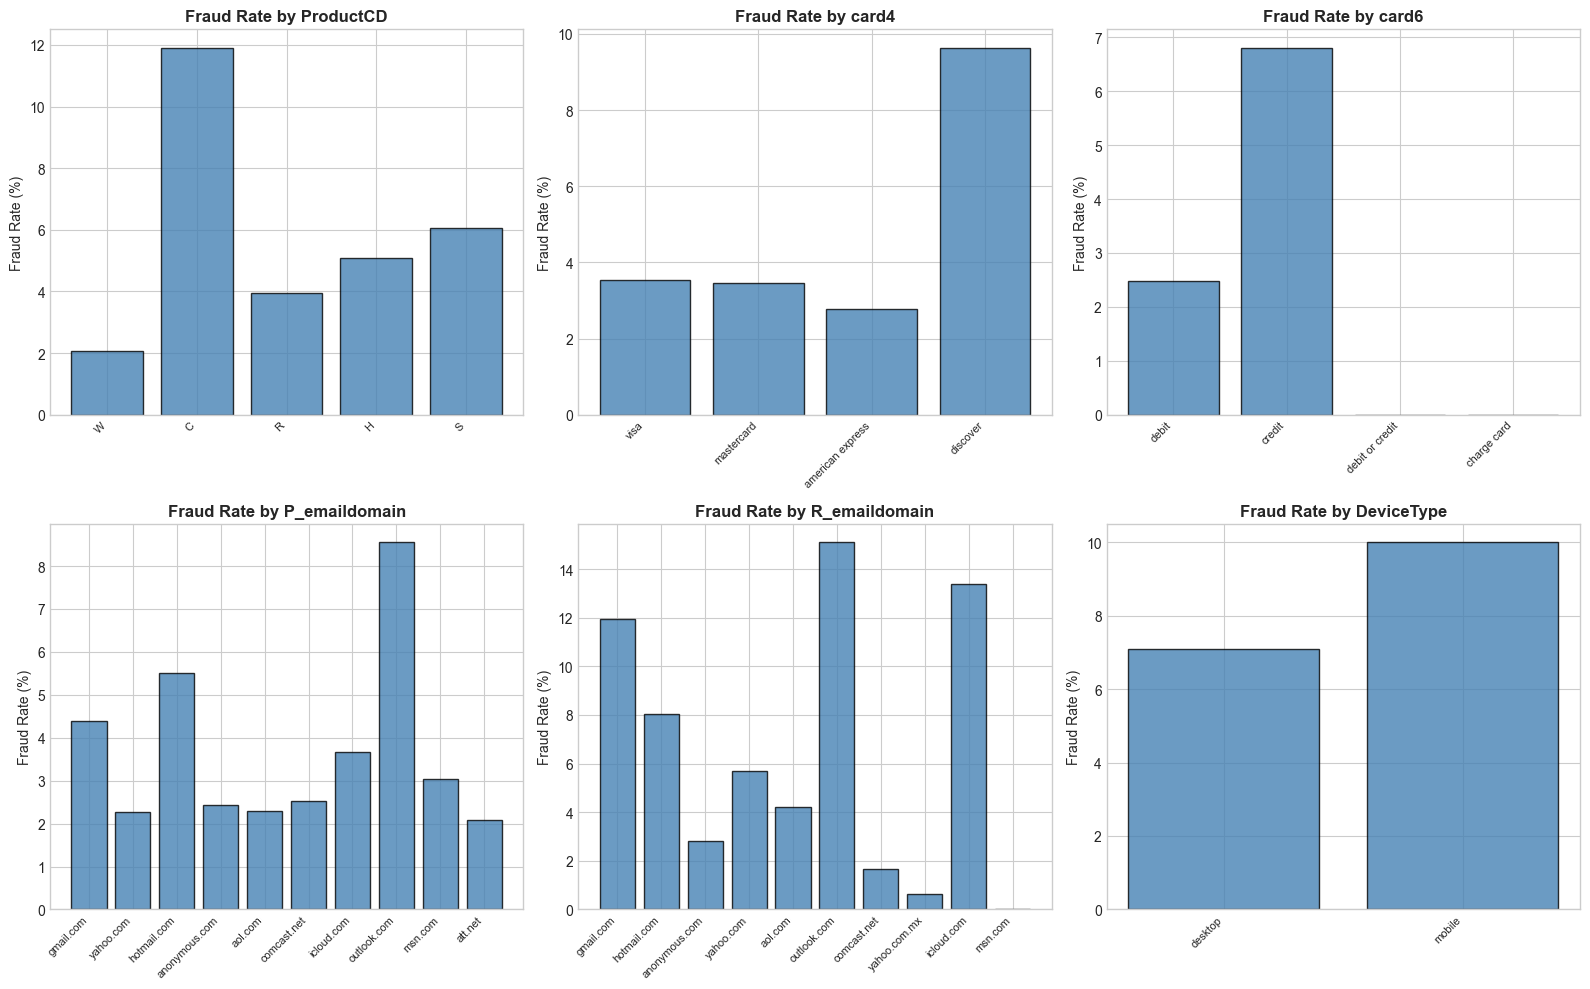

In [20]:
# Fraud rate by categorical features
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, col in enumerate(cat_cols[:6]):
    ax = axes[idx]
    
    # Calculate fraud rate by category
    fraud_rate = data.groupby(col)['isFraud'].agg(['mean', 'count'])
    fraud_rate = fraud_rate.sort_values('count', ascending=False).head(10)
    
    # Plot
    x = range(len(fraud_rate))
    bars = ax.bar(x, fraud_rate['mean'] * 100, color='steelblue', edgecolor='black', alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(fraud_rate.index, rotation=45, ha='right', fontsize=8)
    ax.set_ylabel('Fraud Rate (%)')
    ax.set_title(f'Fraud Rate by {col}', fontweight='bold')

for idx in range(len(cat_cols), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'categorical_features.png'), dpi=150, bbox_inches='tight')
plt.show()

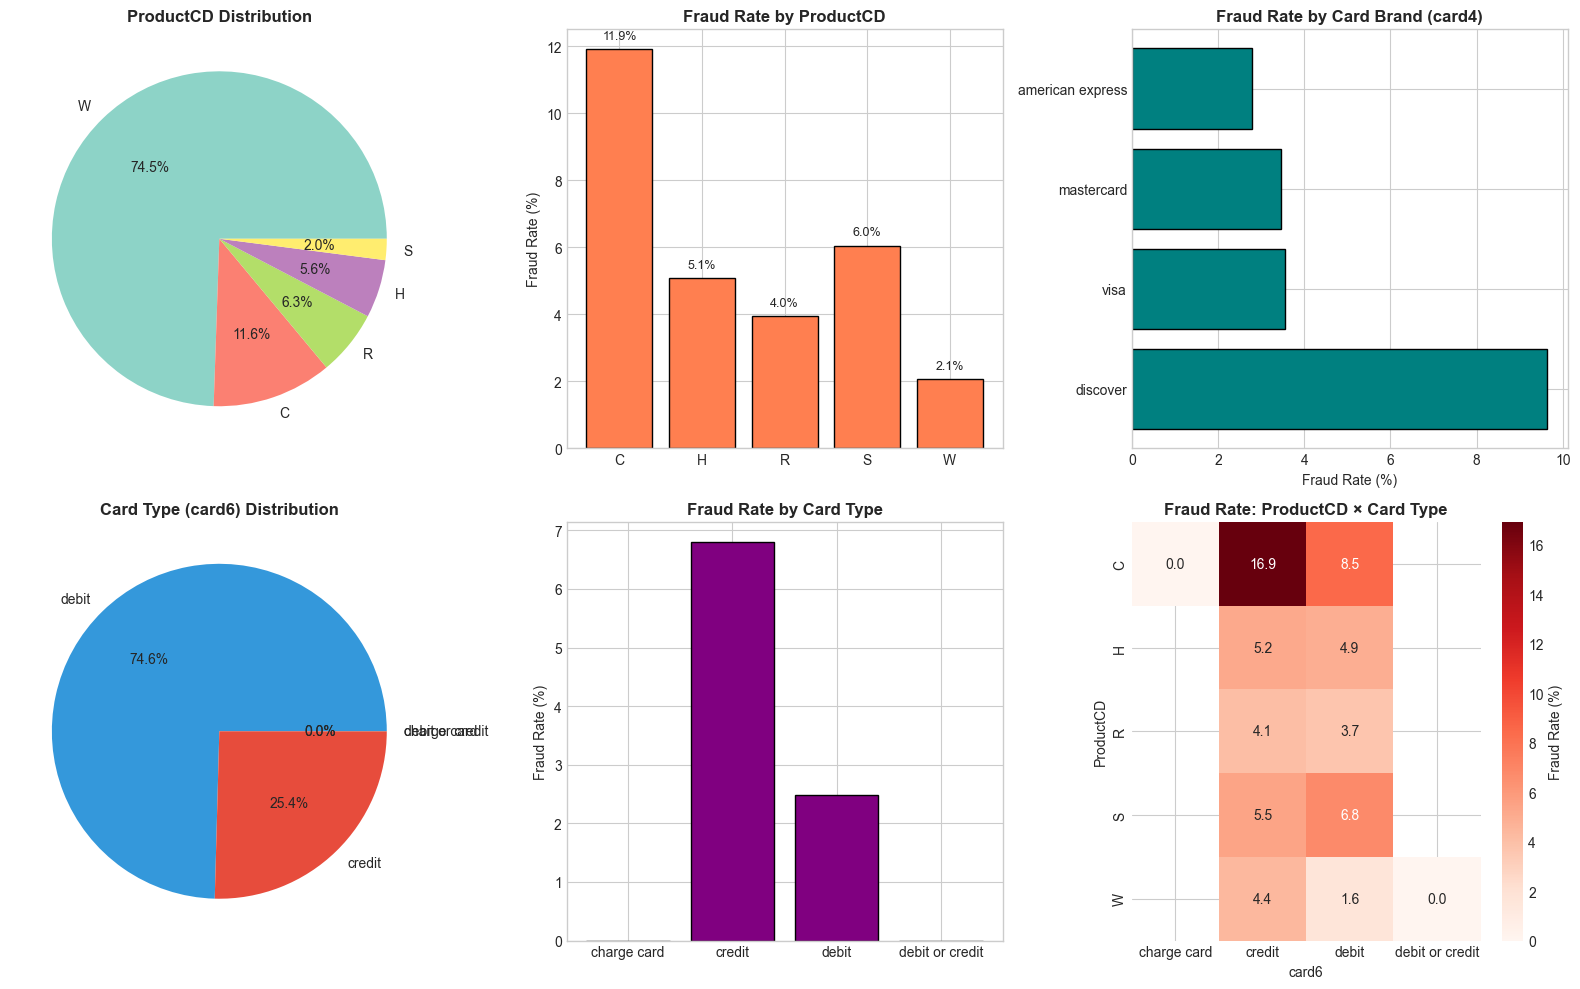

In [21]:
# ProductCD and Card detailed analysis
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# ProductCD distribution
ax = axes[0, 0]
product_counts = data['ProductCD'].value_counts()
colors = plt.cm.Set3(np.linspace(0, 1, len(product_counts)))
ax.pie(product_counts, labels=product_counts.index, colors=colors, autopct='%1.1f%%')
ax.set_title('ProductCD Distribution', fontweight='bold')

# ProductCD fraud rate
ax = axes[0, 1]
product_fraud = data.groupby('ProductCD')['isFraud'].mean() * 100
bars = ax.bar(product_fraud.index, product_fraud.values, color='coral', edgecolor='black')
ax.set_ylabel('Fraud Rate (%)')
ax.set_title('Fraud Rate by ProductCD', fontweight='bold')
for bar, val in zip(bars, product_fraud.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
           f'{val:.1f}%', ha='center', fontsize=9)

# Card4 (card brand)
ax = axes[0, 2]
if 'card4' in data.columns:
    card4_fraud = data.groupby('card4')['isFraud'].mean() * 100
    card4_fraud = card4_fraud.sort_values(ascending=False)
    ax.barh(range(len(card4_fraud)), card4_fraud.values, color='teal', edgecolor='black')
    ax.set_yticks(range(len(card4_fraud)))
    ax.set_yticklabels(card4_fraud.index)
    ax.set_xlabel('Fraud Rate (%)')
    ax.set_title('Fraud Rate by Card Brand (card4)', fontweight='bold')

# Card6 (card type)
ax = axes[1, 0]
if 'card6' in data.columns:
    card6_counts = data['card6'].value_counts()
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f1c40f'][:len(card6_counts)]
    ax.pie(card6_counts, labels=card6_counts.index, colors=colors, autopct='%1.1f%%')
    ax.set_title('Card Type (card6) Distribution', fontweight='bold')

# Card6 fraud rate
ax = axes[1, 1]
if 'card6' in data.columns:
    card6_fraud = data.groupby('card6')['isFraud'].mean() * 100
    bars = ax.bar(card6_fraud.index, card6_fraud.values, color='purple', edgecolor='black')
    ax.set_ylabel('Fraud Rate (%)')
    ax.set_title('Fraud Rate by Card Type', fontweight='bold')

# Cross-tabulation heatmap
ax = axes[1, 2]
if 'card6' in data.columns:
    cross_fraud = data.pivot_table(values='isFraud', index='ProductCD', 
                                    columns='card6', aggfunc='mean') * 100
    sns.heatmap(cross_fraud, annot=True, fmt='.1f', cmap='Reds', ax=ax, 
               cbar_kws={'label': 'Fraud Rate (%)'})
    ax.set_title('Fraud Rate: ProductCD × Card Type', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'product_card_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

---
# 7. V Features Analysis (Vesta Engineered)

In [22]:
v_cols = [c for c in data.columns if c.startswith('V')]
print(f"Number of V features: {len(v_cols)}")

# Missing value analysis
v_missing = data[v_cols].isnull().sum() / len(data) * 100
print(f"\nV Features Missing Value Summary:")
print(f"  Mean missing %: {v_missing.mean():.1f}%")
print(f"  Max missing %:  {v_missing.max():.1f}%")
print(f"  Features with >50% missing: {(v_missing > 50).sum()}")

Number of V features: 339

V Features Missing Value Summary:
  Mean missing %: 43.1%
  Max missing %:  86.1%
  Features with >50% missing: 159


In [23]:
# Calculate correlations with fraud
v_fraud_corr = {}
for col in v_cols:
    if data[col].notna().sum() > 100:
        corr = data[col].corr(data['isFraud'])
        if not np.isnan(corr):
            v_fraud_corr[col] = corr

sorted_corr = sorted(v_fraud_corr.items(), key=lambda x: abs(x[1]), reverse=True)

print("Top 15 V features by absolute correlation with fraud:")
for col, corr in sorted_corr[:15]:
    print(f"  {col}: {corr:+.4f}")

Top 15 V features by absolute correlation with fraud:
  V257: +0.3806
  V246: +0.3650
  V244: +0.3487
  V242: +0.3475
  V201: +0.3238
  V258: +0.3204
  V200: +0.3059
  V189: +0.2996
  V158: +0.2972
  V156: +0.2939
  V149: +0.2897
  V188: +0.2807
  V45: +0.2744
  V147: +0.2717
  V228: +0.2609


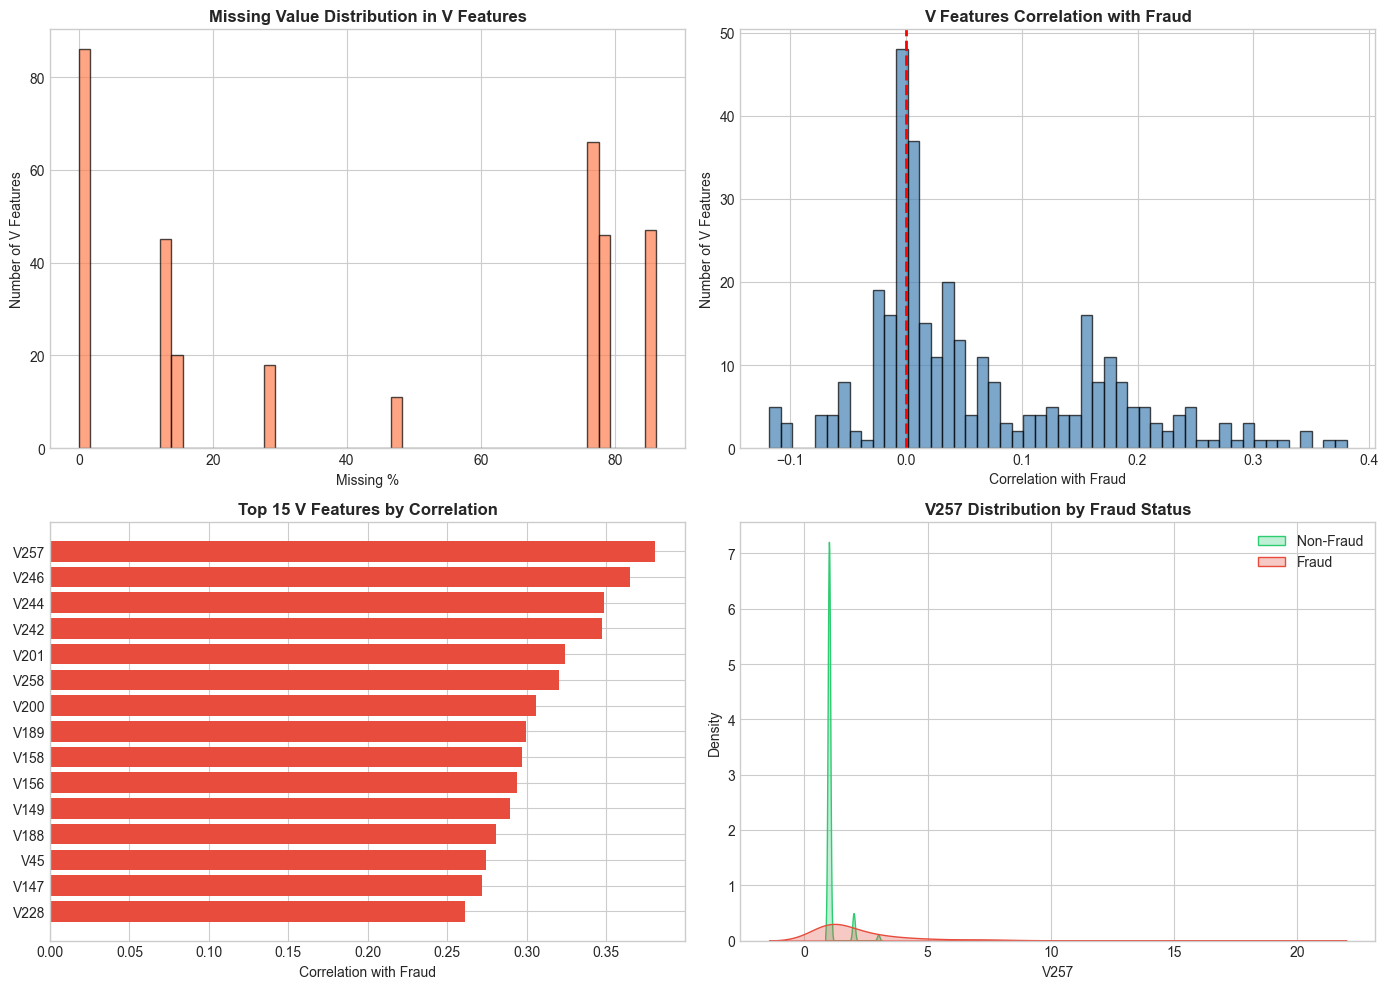

In [24]:
# Visualize V features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Missing values
ax = axes[0, 0]
ax.hist(v_missing, bins=50, color='coral', edgecolor='black', alpha=0.7)
ax.set_xlabel('Missing %')
ax.set_ylabel('Number of V Features')
ax.set_title('Missing Value Distribution in V Features', fontweight='bold')

# Correlation distribution
ax = axes[0, 1]
corr_values = list(v_fraud_corr.values())
ax.hist(corr_values, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Correlation with Fraud')
ax.set_ylabel('Number of V Features')
ax.set_title('V Features Correlation with Fraud', fontweight='bold')

# Top correlations
ax = axes[1, 0]
top_pos = sorted_corr[:15]
cols = [x[0] for x in top_pos]
vals = [x[1] for x in top_pos]
colors = ['#e74c3c' if v > 0 else '#3498db' for v in vals]
ax.barh(range(len(cols)), vals, color=colors)
ax.set_yticks(range(len(cols)))
ax.set_yticklabels(cols)
ax.set_xlabel('Correlation with Fraud')
ax.set_title('Top 15 V Features by Correlation', fontweight='bold')
ax.axvline(0, color='black', linewidth=0.5)
ax.invert_yaxis()

# Top V feature distribution by fraud
ax = axes[1, 1]
if len(sorted_corr) > 0:
    top_v = sorted_corr[0][0]
    for label, name, color in [(0, 'Non-Fraud', '#2ecc71'), (1, 'Fraud', '#e74c3c')]:
        subset = data[data['isFraud'] == label][top_v].dropna()
        if len(subset) > 0:
            sns.kdeplot(subset.clip(subset.quantile(0.01), subset.quantile(0.99)), 
                       ax=ax, label=name, color=color, fill=True, alpha=0.3)
    ax.set_xlabel(top_v)
    ax.set_ylabel('Density')
    ax.set_title(f'{top_v} Distribution by Fraud Status', fontweight='bold')
    ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'v_features.png'), dpi=150, bbox_inches='tight')
plt.show()

---
# 8. Temporal Analysis

In [25]:
# Extract time features
data['hour'] = data['datetime'].dt.hour
data['day_of_week'] = data['datetime'].dt.dayofweek
data['day_of_month'] = data['datetime'].dt.day
data['date'] = data['datetime'].dt.date

print("Hourly Pattern:")
hourly_fraud = data.groupby('hour')['isFraud'].mean() * 100
print(f"  Peak fraud hour: {hourly_fraud.idxmax()} ({hourly_fraud.max():.2f}%)")
print(f"  Lowest fraud hour: {hourly_fraud.idxmin()} ({hourly_fraud.min():.2f}%)")

Hourly Pattern:
  Peak fraud hour: 9 (10.91%)
  Lowest fraud hour: 13 (1.95%)


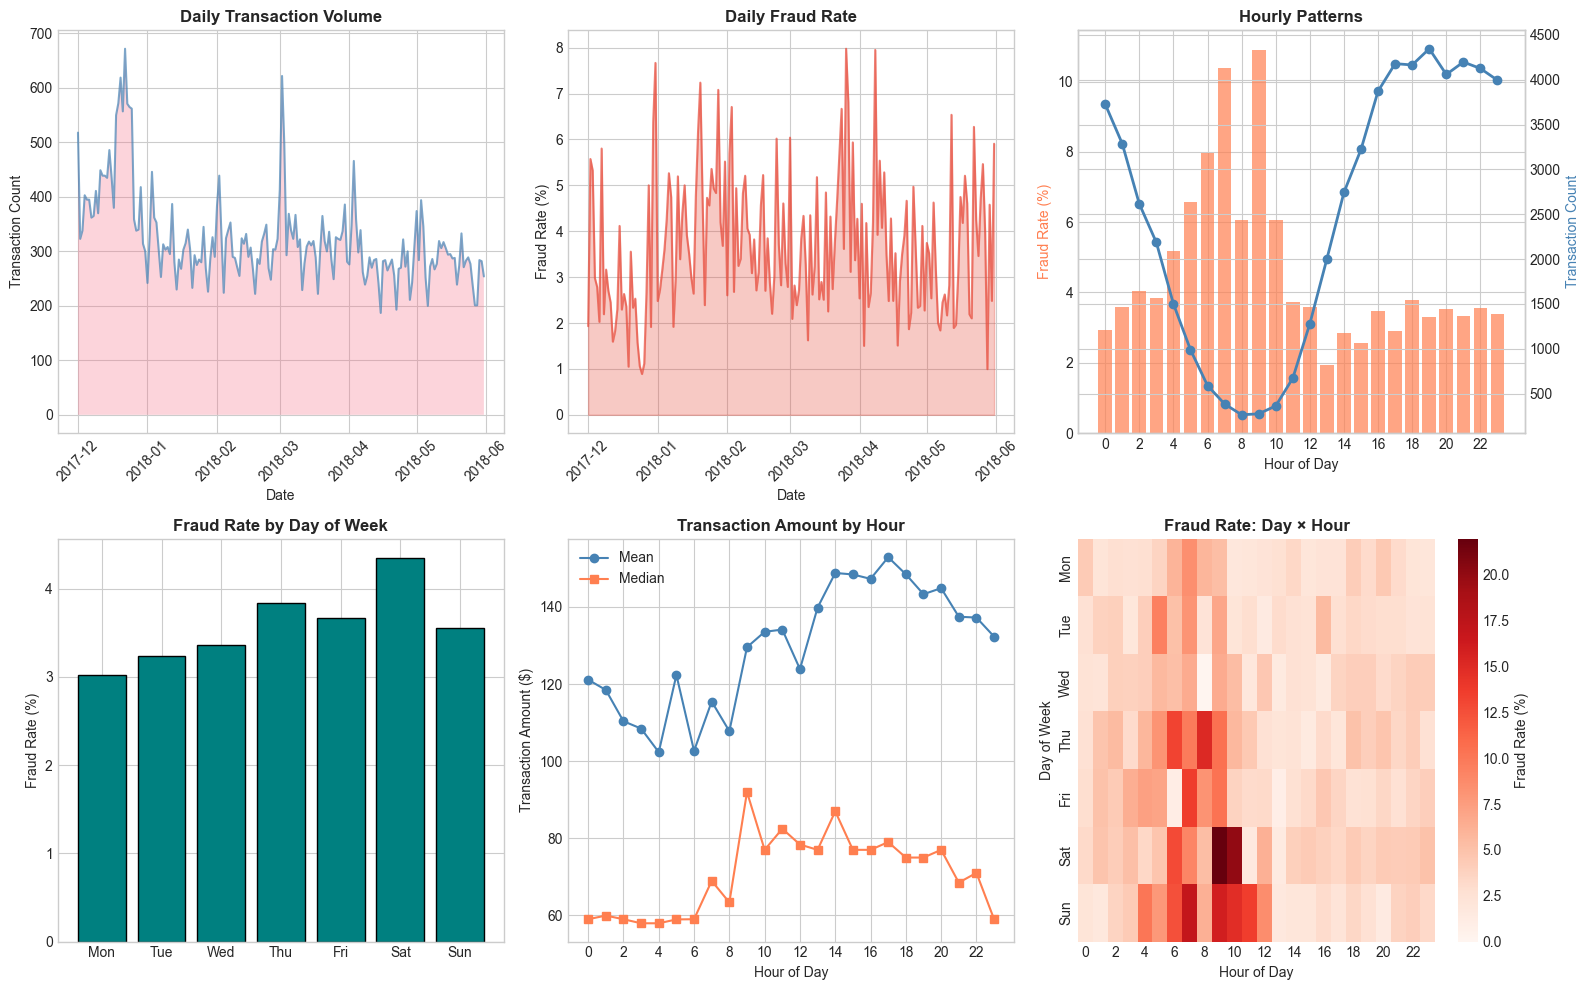

In [26]:
# Temporal visualizations
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Daily transaction volume
ax = axes[0, 0]
daily_txn = data.groupby('date').size()
ax.plot(daily_txn.index, daily_txn.values, color='steelblue', alpha=0.7)
ax.fill_between(daily_txn.index, daily_txn.values, alpha=0.3)
ax.set_xlabel('Date')
ax.set_ylabel('Transaction Count')
ax.set_title('Daily Transaction Volume', fontweight='bold')
ax.tick_params(axis='x', rotation=45)

# Daily fraud rate
ax = axes[0, 1]
daily_fraud = data.groupby('date')['isFraud'].mean() * 100
ax.plot(daily_fraud.index, daily_fraud.values, color='#e74c3c', alpha=0.7)
ax.fill_between(daily_fraud.index, daily_fraud.values, alpha=0.3, color='#e74c3c')
ax.set_xlabel('Date')
ax.set_ylabel('Fraud Rate (%)')
ax.set_title('Daily Fraud Rate', fontweight='bold')
ax.tick_params(axis='x', rotation=45)

# Hourly pattern
ax = axes[0, 2]
hourly_stats = data.groupby('hour').agg({'isFraud': 'mean', 'TransactionAmt': 'count'})
ax2 = ax.twinx()
ax.bar(hourly_stats.index, hourly_stats['isFraud'] * 100, alpha=0.7, color='coral', label='Fraud Rate')
ax2.plot(hourly_stats.index, hourly_stats['TransactionAmt'], color='steelblue', linewidth=2, marker='o')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Fraud Rate (%)', color='coral')
ax2.set_ylabel('Transaction Count', color='steelblue')
ax.set_title('Hourly Patterns', fontweight='bold')
ax.set_xticks(range(0, 24, 2))

# Day of week
ax = axes[1, 0]
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
dow_fraud = data.groupby('day_of_week')['isFraud'].mean() * 100
ax.bar(dow_names, dow_fraud.values, color='teal', edgecolor='black')
ax.set_ylabel('Fraud Rate (%)')
ax.set_title('Fraud Rate by Day of Week', fontweight='bold')

# Amount by hour
ax = axes[1, 1]
hourly_amt = data.groupby('hour')['TransactionAmt'].agg(['mean', 'median'])
ax.plot(hourly_amt.index, hourly_amt['mean'], marker='o', label='Mean', color='steelblue')
ax.plot(hourly_amt.index, hourly_amt['median'], marker='s', label='Median', color='coral')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Transaction Amount ($)')
ax.set_title('Transaction Amount by Hour', fontweight='bold')
ax.legend()
ax.set_xticks(range(0, 24, 2))

# Fraud heatmap: hour vs day
ax = axes[1, 2]
heatmap_data = data.pivot_table(values='isFraud', index='day_of_week', 
                                 columns='hour', aggfunc='mean') * 100
heatmap_data.index = dow_names
sns.heatmap(heatmap_data, cmap='Reds', ax=ax, cbar_kws={'label': 'Fraud Rate (%)'})
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Day of Week')
ax.set_title('Fraud Rate: Day × Hour', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'temporal_patterns.png'), dpi=150, bbox_inches='tight')
plt.show()

---
# 9. Correlation Analysis

In [27]:
# Calculate correlations with fraud for all numerical columns
num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in ['isFraud', 'TransactionID']]

fraud_corr = {}
for col in num_cols:
    if data[col].notna().sum() > 100:
        corr = data[col].corr(data['isFraud'])
        if not np.isnan(corr):
            fraud_corr[col] = corr

sorted_all_corr = sorted(fraud_corr.items(), key=lambda x: abs(x[1]), reverse=True)

print("Top 20 features by absolute correlation with fraud:")
for col, corr in sorted_all_corr[:20]:
    print(f"  {col:30s}: {corr:+.4f}")

Top 20 features by absolute correlation with fraud:
  V257                          : +0.3806
  V246                          : +0.3650
  V244                          : +0.3487
  V242                          : +0.3475
  V201                          : +0.3238
  V258                          : +0.3204
  V200                          : +0.3059
  V189                          : +0.2996
  V158                          : +0.2972
  V156                          : +0.2939
  V149                          : +0.2897
  V188                          : +0.2807
  V45                           : +0.2744
  V147                          : +0.2717
  V228                          : +0.2609
  V44                           : +0.2566
  V230                          : +0.2473
  V87                           : +0.2470
  V86                           : +0.2443
  V170                          : +0.2418


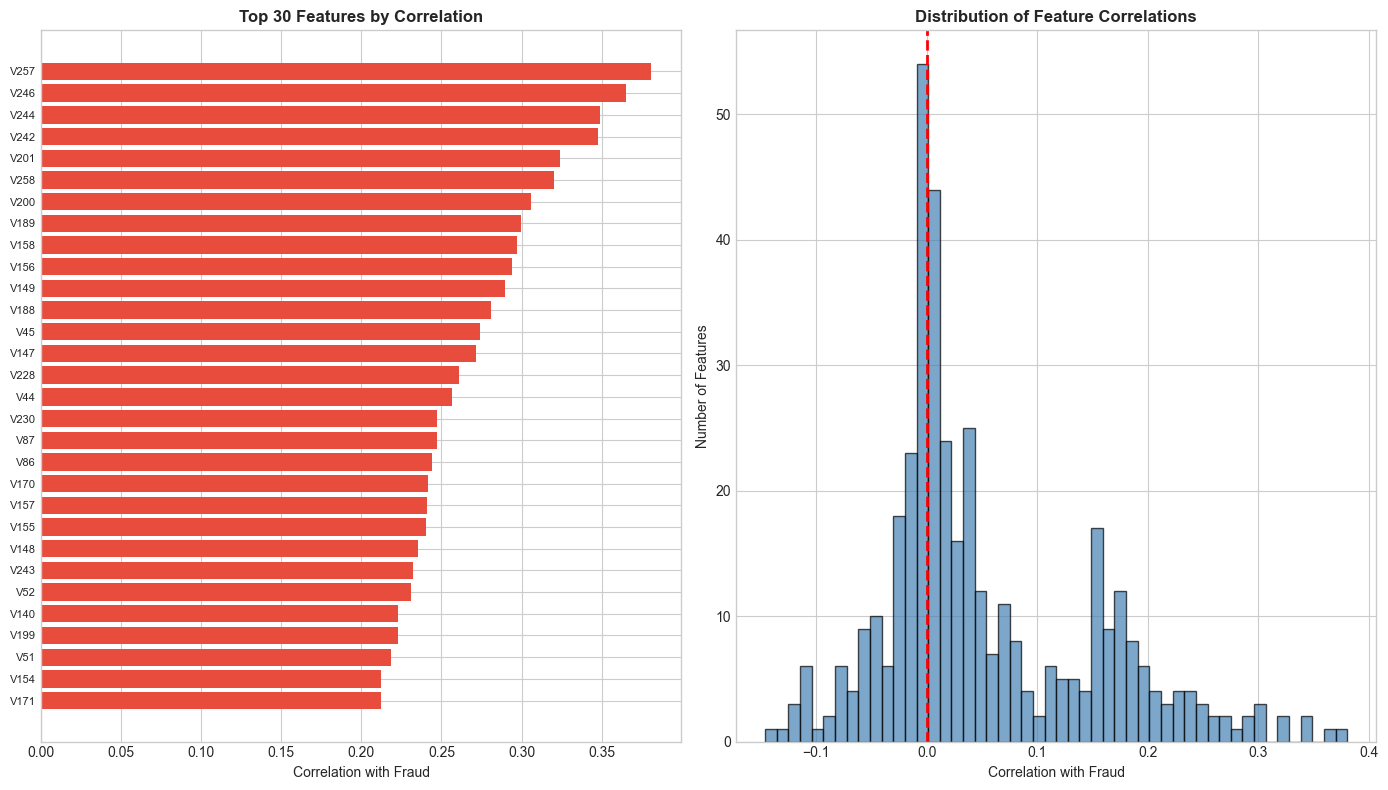

In [28]:
# Visualize correlations
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Top correlations
ax = axes[0]
top_30 = sorted_all_corr[:30]
cols = [x[0] for x in top_30]
vals = [x[1] for x in top_30]
colors = ['#e74c3c' if c > 0 else '#3498db' for c in vals]
ax.barh(range(len(cols)), vals, color=colors)
ax.set_yticks(range(len(cols)))
ax.set_yticklabels(cols, fontsize=8)
ax.set_xlabel('Correlation with Fraud')
ax.set_title('Top 30 Features by Correlation', fontweight='bold')
ax.axvline(0, color='black', linewidth=0.5)
ax.invert_yaxis()

# Correlation distribution
ax = axes[1]
all_corrs = [x[1] for x in sorted_all_corr]
ax.hist(all_corrs, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Correlation with Fraud')
ax.set_ylabel('Number of Features')
ax.set_title('Distribution of Feature Correlations', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'correlations.png'), dpi=150, bbox_inches='tight')
plt.show()

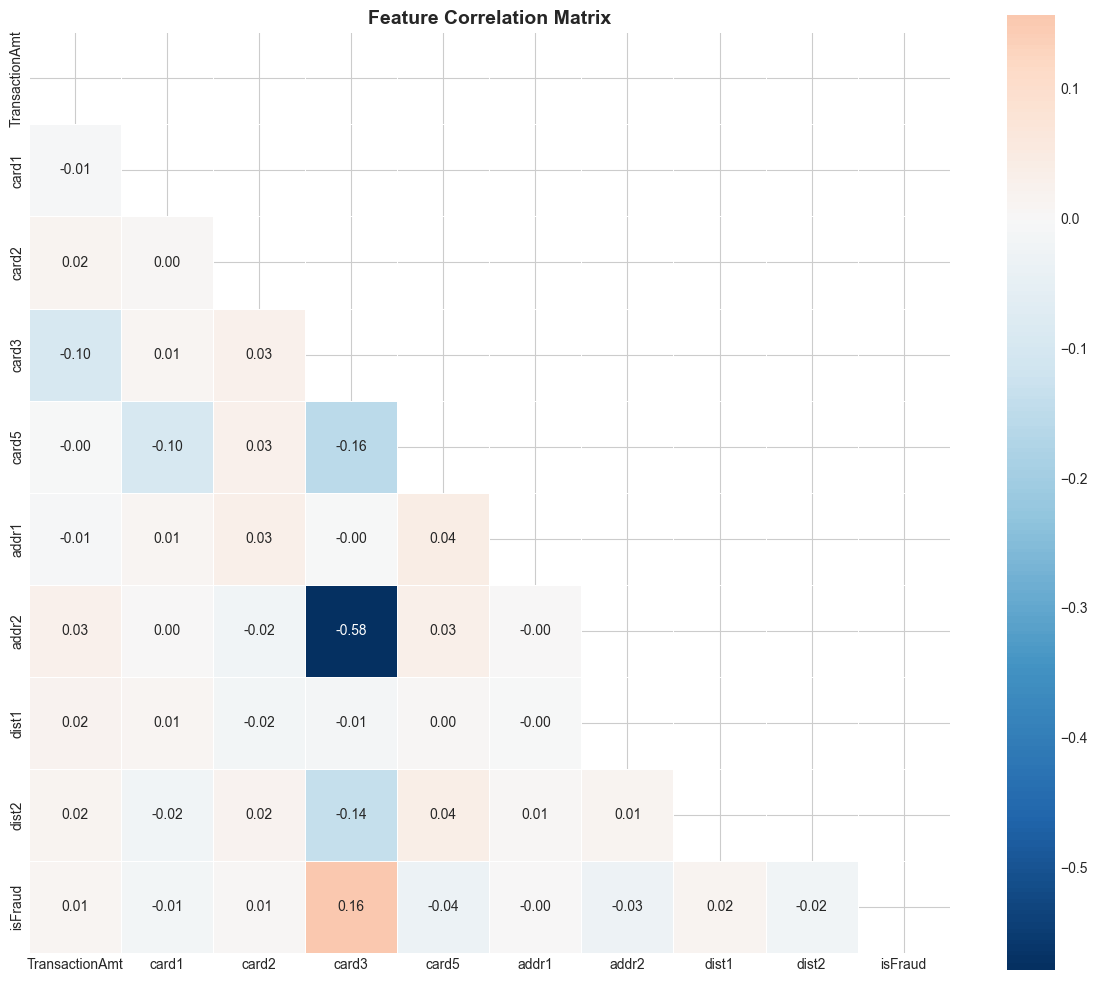

In [29]:
# Correlation matrix for key features
key_features = ['TransactionAmt', 'card1', 'card2', 'card3', 'card5',
               'addr1', 'addr2', 'dist1', 'dist2', 'isFraud']
key_features = [f for f in key_features if f in data.columns]

corr_matrix = data[key_features].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'correlation_matrix.png'), dpi=150, bbox_inches='tight')
plt.show()

---
# 10. Interactive Visualizations (Plotly)

In [49]:
if PLOTLY_AVAILABLE:
    # Sample for performance
    sample_size = min(50000, len(data))
    sample_data = data.sample(sample_size, random_state=42)
    print(f"Using {sample_size:,} samples for interactive plots")
else:
    print("Plotly not available. Install with: pip install plotly")

Using 50,000 samples for interactive plots


In [50]:
# Interactive box plot: Amount by Fraud Status
if PLOTLY_AVAILABLE:
    fig = px.box(sample_data, x='isFraud', y='TransactionAmt', 
                  color='isFraud', log_y=True,
                  title='Transaction Amount by Fraud Status',
                  labels={'isFraud': 'Is Fraud', 'TransactionAmt': 'Amount ($)'},
                  color_discrete_map={0: '#2ecc71', 1: '#e74c3c'})
    fig.show()

In [51]:
# Interactive sunburst: ProductCD → card4 → Fraud
if PLOTLY_AVAILABLE and 'card4' in sample_data.columns:
    sunburst_data = sample_data.groupby(['ProductCD', 'card4', 'isFraud']).size().reset_index(name='count')
    fig = px.sunburst(sunburst_data, path=['ProductCD', 'card4', 'isFraud'], 
                       values='count', title='Transaction Hierarchy: Product → Card Brand → Fraud')
    fig.show()

In [52]:
# Interactive time series
if PLOTLY_AVAILABLE:
    daily_stats = sample_data.groupby('date').agg({
        'isFraud': ['sum', 'mean', 'count']
    }).reset_index()
    daily_stats.columns = ['date', 'fraud_count', 'fraud_rate', 'total_count']
    daily_stats['fraud_rate'] *= 100
    
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                         subplot_titles=('Daily Transaction Volume', 'Daily Fraud Rate (%)'))
    fig.add_trace(go.Scatter(x=daily_stats['date'], y=daily_stats['total_count'],
                              fill='tozeroy', name='Transactions'), row=1, col=1)
    fig.add_trace(go.Scatter(x=daily_stats['date'], y=daily_stats['fraud_rate'],
                              fill='tozeroy', name='Fraud Rate', line=dict(color='red')), row=2, col=1)
    fig.update_layout(title='Time Series Analysis', height=600)
    fig.show()

In [53]:
# Interactive 3D scatter
if PLOTLY_AVAILABLE:
    scatter_sample = sample_data.sample(min(10000, len(sample_data)))
    fig = px.scatter_3d(scatter_sample, 
                         x='TransactionAmt', y='hour', z='card1',
                         color='isFraud', opacity=0.5,
                         title='3D View: Amount × Hour × Card1',
                         color_discrete_map={0: '#2ecc71', 1: '#e74c3c'})
    fig.update_traces(marker=dict(size=3))
    fig.show()

In [54]:
# Parallel coordinates
if PLOTLY_AVAILABLE:
    parallel_features = ['TransactionAmt', 'card1', 'addr1', 'dist1', 'isFraud']
    parallel_features = [f for f in parallel_features if f in sample_data.columns]
    parallel_sample = sample_data[parallel_features].dropna().sample(min(5000, len(sample_data)))
    
    fig = px.parallel_coordinates(parallel_sample, color='isFraud',
                                   title='Parallel Coordinates: Key Features',
                                   color_continuous_scale=[[0, '#2ecc71'], [1, '#e74c3c']])
    fig.show()

---
# 11. Summary & Key Insights

In [55]:
print("="*70)
print("  IEEE-CIS FRAUD DETECTION - EDA SUMMARY")
print("="*70)

print(f"\n📊 Dataset Size: {len(data):,} transactions, {len(data.columns)} features")
print(f"📅 Date Range: {data['datetime'].min().date()} to {data['datetime'].max().date()}")

fraud_rate = data['isFraud'].mean() * 100
print(f"\n🎯 Fraud Rate: {fraud_rate:.2f}%")
print(f"   Imbalance Ratio: {(100-fraud_rate)/fraud_rate:.1f}:1")

print(f"\n💰 Transaction Amount:")
print(f"   Mean: ${data['TransactionAmt'].mean():.2f}")
print(f"   Median: ${data['TransactionAmt'].median():.2f}")

print(f"\n⚠️  Missing Values:")
cols_with_missing = (data.isnull().sum() > 0).sum()
print(f"   {cols_with_missing} columns with missing values")
print(f"   {(data.isnull().sum() > len(data)*0.5).sum()} columns with >50% missing")

print(f"\n🔗 Top 5 Correlated Features:")
for col, corr in sorted_all_corr[:5]:
    print(f"   {col}: {corr:+.4f}")

print(f"\n📁 Outputs saved to: {OUTPUT_DIR}/")
print("="*70)

  IEEE-CIS FRAUD DETECTION - EDA SUMMARY

📊 Dataset Size: 59,054 transactions, 439 features
📅 Date Range: 2017-12-01 to 2018-05-31

🎯 Fraud Rate: 3.57%
   Imbalance Ratio: 27.0:1

💰 Transaction Amount:
   Mean: $135.24
   Median: $68.50

⚠️  Missing Values:
   382 columns with missing values
   214 columns with >50% missing

🔗 Top 5 Correlated Features:
   V257: +0.3806
   V246: +0.3650
   V244: +0.3487
   V242: +0.3475
   V201: +0.3238

📁 Outputs saved to: eda_output/


In [56]:
# Save correlation data
corr_df = pd.DataFrame(sorted_all_corr, columns=['feature', 'correlation'])
corr_df.to_csv(os.path.join(OUTPUT_DIR, 'feature_correlations.csv'), index=False)
print(f"Saved feature correlations to {OUTPUT_DIR}/feature_correlations.csv")

Saved feature correlations to eda_output/feature_correlations.csv
